# DATA 512 - Project Part 1: Common Analysis

## Wildfires Analysis - Creation of a Smoke Estimate and its Modeling

### Tanushree Yandra, University of Washington, Seattle

More and more frequently, summers in the western US have been characterized by wildfires with smoke billowing across multiple western states. There are many proposed causes for this: climate change, US Forestry policy, growing awareness, just to name a few. Regardless of the cause, the impact of wildland fires is widespread. There is a growing body of work pointing to the negative impacts of smoke on health, tourism, property, and other aspects of society. This project analyzes wildfire impacts on the city of Twin Falls, Idaho in the US. The end goal is to be able to inform policy makers, city managers, city councils, or other civic institutions, to make an informed plan for how they could or whether they should make plans to mitigate future impacts from wildfires.

Wildland fires within 1250 miles of Twin Falls, Idaho are analyzed for the last 60 years (1963-2020). This section of the notebook uses the [Processed Wildfires Dataset]() generated from the [Wildfire Analysis - Data Preprocessing notebook](), and the [Yearly AQI Data]() generated from the [Wildfire Analysis - Data Retrieval notebook](). Using these datasets, a smoke estimate is created which is then evaluated using the AQI levels. The smoke estimate is then modeled to generate predictions from 2021 to 2049. Some visualizations are also created at the end to generate further insights.

### Step 1: Preliminaries

First, we start by importing required packages and modules.

In [1]:
# These are standard python modules
import pandas as pd
import warnings

# The modules below are not standard Python modules
# You will need to install these with pip/pip3 if you do not already have it
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Suppress the warning statements
warnings.filterwarnings("ignore")

### Step 2: Read the Processed Wildfires Dataset

We will now load the processed wildfires data into a dataframe.

In [3]:
# Read the CSV data into a dataframe
wf_df = pd.read_csv('Wildfire_Data_Processed.csv')

In [4]:
# Look at the top of the dataframe
wf_df.head()

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,GIS_Acres,Listed_Fire_Names,Circleness_Scale,Shape_Length,Shape_Area,Distance
0,14299,Wildfire,1963,40992.458271,RATTLESNAKE (4),0.385355,73550.428118,1.658906e+08,160.949890
1,14300,Wildfire,1963,25757.090203,McChord Butte (2),0.364815,59920.576713,1.042352e+08,187.994096
2,14301,Wildfire,1963,45527.210986,WILLOW CREEK (16),0.320927,84936.827810,1.842421e+08,160.517096
3,14302,Wildfire,1963,10395.010334,SOUTH CANYON CREEK (4),0.428936,35105.903602,4.206711e+07,80.011735
4,14303,Wildfire,1963,9983.605738,WEBB CREEK (4),0.703178,26870.456126,4.040222e+07,144.899050


In [5]:
# Look at the shape of the dataframe
wf_df.shape

(72608, 9)

Our wildfires data has 72608 instances of wildfires with 9 features.

### Step 3: Creating a Smoke Estimate

Now, we need to create an annual estimate of wildfire smoke in Twin Falls, Idaho. This estimate is just a number that we will eventually use to build a predictive model. It seems reasonable that a large fire burning a large number of acres, and that is close to our city would put more smoke into a city than a small fire that is much further away. We will thus use the variables 'GIS_Acres' and 'Distance' to define our smoke estimate and then apply it to every fire within 1250 miles of our city between 1963 and 2020.

Before that, we need to make the two variables consistent in terms of their units. This is done by converting the 'GIS_Acres' variable to square miles since the 'Distance' values are stored as miles. 

In [6]:
# Convert 'GIS_Acres' to square miles and store the values in a new column 'GIS_Square_Miles'
wf_df['GIS_Square_Miles'] = wf_df['GIS_Acres']*0.0015625

Now, we will plot the two variables to understand their inherent relationship. This will help us create our smoke estimate accordingly.

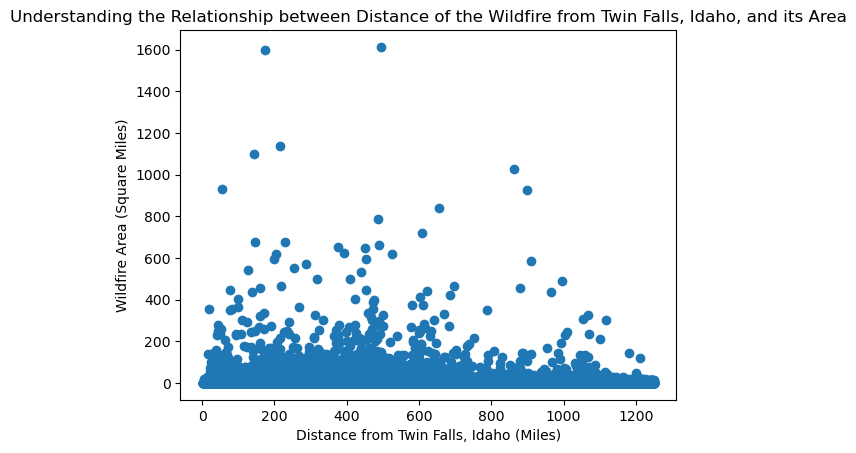

In [7]:
# Plotting 'Distance' and 'GIS_Square_Miles'
plt.scatter(wf_df['Distance'], wf_df['GIS_Square_Miles'])

# Set labels and show plot
plt.xlabel('Distance from Twin Falls, Idaho (Miles)')
plt.ylabel('Wildfire Area (Square Miles)')
plt.title('Understanding the Relationship between Distance of the Wildfire from Twin Falls, Idaho, and its Area')
plt.show()

The relationship in the above plot looks pretty random where most of the wildfires are concetrated in smaller areas region. There is no apparent relationship visible.

Let's try plotting the square of the 'Distance' with the 'GIS_Square_Miles' variable.

In [8]:
# Compute the square of the distance and store it in a new column called 'Distance_Square'
wf_df['Distance_Square'] = (wf_df['Distance'])**2

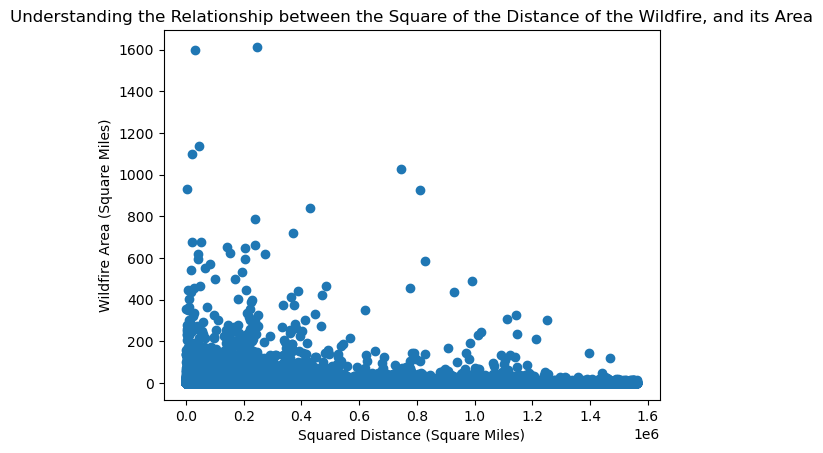

In [9]:
# Plotting 'Distance_Square' and 'GIS_Square_Miles'
plt.scatter(wf_df['Distance_Square'], wf_df['GIS_Square_Miles'])

# Set labels and show plot
plt.xlabel('Squared Distance (Square Miles)')
plt.ylabel('Wildfire Area (Square Miles)')
plt.title('Understanding the Relationship between the Square of the Distance of the Wildfire, and its Area')
plt.show()

There seems to be some improvement in the manner in which the points are scattered. It can be observed that the data points that whose square of distance is smaller, tend to have a higher area. The relationship can be approximated to a decaying exponential function.

Thus, the smoke estimate that best captures our intuition can be created using the following formula,

*Smoke Estimate = w1 x Area of Fire x exp(-w2 x Distance^2)*

The aim is to not have a very high smoke estimate value. The intention is to keep it under 50. Based on the existing data points, w1 and w2 were chosen in such a way that the overall smoke estimate value stays under 50. Thus w1 and w2 for this analysis were chosen only to keep the number of digits of 'Distance_Square' and 'Area' under control.

Since 'GIS_Square_Miles' is usually in hundreds, w1 is chosen as 1/100 to reduce the overall value of smoke estimate. Similarly, since 'Distance_Square' is a very high value usually in hundred thousands, w2 is chosen as 1/100000 to curb the digits. Thus, the final smoke estimate looks as follows,

*Smoke Estimate = (Area of Fire x exp(Distance^2/100000))/100*

Using the above formula, smoke estimate is calculated for every fire in the dataset.

In [10]:
# Calculate Smoke Estimate for every fire in the dataset
wf_df['Smoke_Estimate'] = wf_df['GIS_Square_Miles']*np.exp(-wf_df['Distance_Square']/100000)/100

### Step 4: Analyzing the Smoke Estimate

The next step is to understand how the smoke estimate for each fire will be used to find one smoke estimate for eevry year. This can be done by taking the cumulative of smoke estimate during each year or by amortizing over the fire season (May 1st to October 31st).

To make this decision, the total number of wildfires were plotted for every year.

In [11]:
# Group the dataframe by the fire year and find the total number of wildfires for each year
count_by_year = wf_df.groupby(['Fire_Year'])['USGS_Assigned_ID'].count().reset_index()

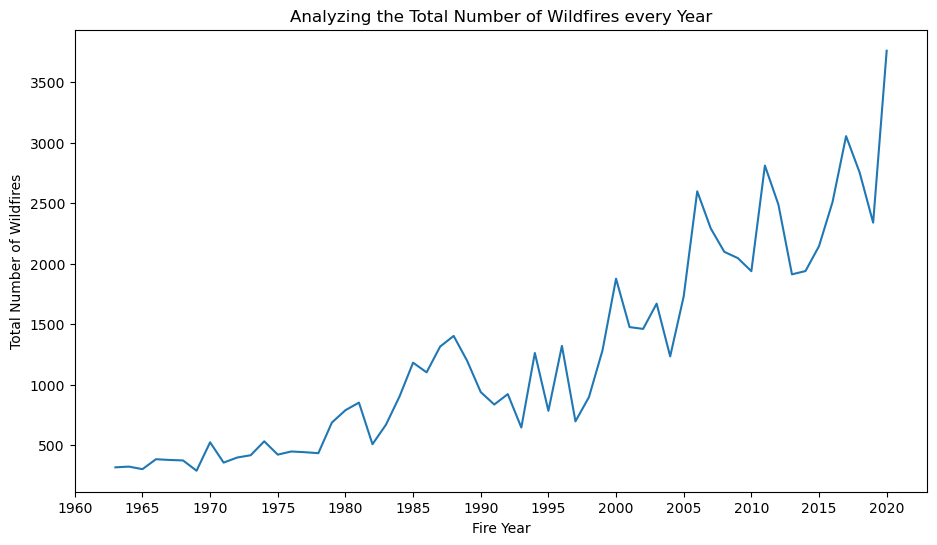

In [12]:
# Plot the total number of wildfires against the fire year
plt.figure(figsize=(11, 6))
plt.plot(count_by_year['Fire_Year'], count_by_year['USGS_Assigned_ID'])

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Total Number of Wildfires')
plt.title('Analyzing the Total Number of Wildfires every Year')
plt.xlim([1960, 2023]) 
plt.xticks(np.arange(1960, 2023, 5))
plt.show()

It can be seen that the total number of wildfires have increased over time. This change has been quite significant from 1963 to 2020. This could also be attributed to the lack of proper reporting measure earlier, but either way, taking an average of the smoke estimate would not account for the total number of wildfires. Since we are analyzing the "smoke emitted", it would make more sense if we take a cumulative of the smoke estimate. This will take the large number of wildfires in recent times into account.

So we now find the Cumulative Smoke Estimate for every year and save it to a new dataframe.

In [13]:
# Create a new dataframe that has yearly data and the cumulative smoke estimate values
smoke_by_year = wf_df.groupby(['Fire_Year'])['Smoke_Estimate'].sum().reset_index()

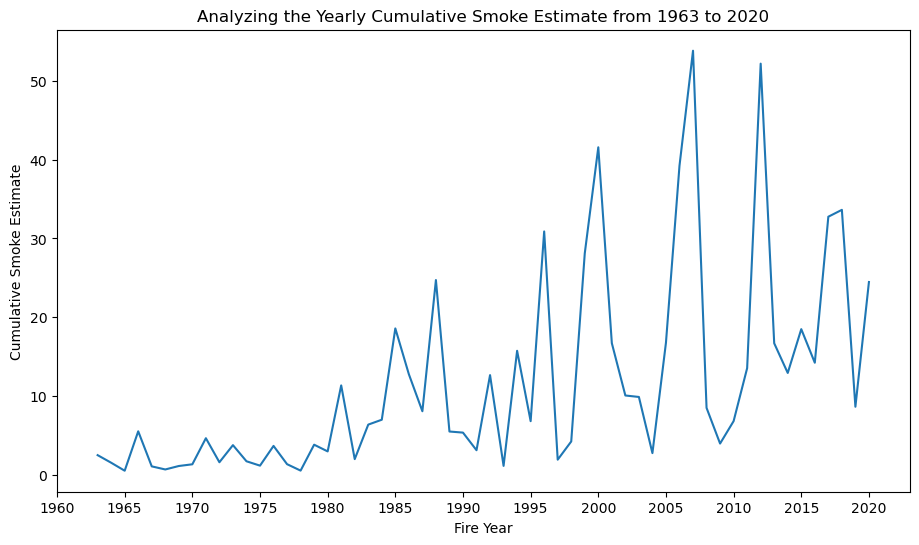

In [14]:
# Plot the cumulative smoke estimate with the fire year
plt.figure(figsize=(11, 6))
plt.plot(smoke_by_year['Fire_Year'], smoke_by_year['Smoke_Estimate'])

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate')
plt.title('Analyzing the Yearly Cumulative Smoke Estimate from 1963 to 2020')
plt.xlim([1960, 2023]) 
plt.xticks(np.arange(1960, 2023, 5))
plt.show()

From the plot above, there seems to be some sort of periodicity existing. The smoke estimate goes up at a peak every 3-5 years. The size of the peaks is also increasing upto the year 2007 after which the peaks have gone down slightly.

### Step 5: Evaluating the Smoke Estimate's Performance Using US EPA Air Quality Data

The next step is trying to understand how good or bad our smoke estimate might be. Now that we have developed our smoke estimate, we will compare our estimate to the AQI (Air Quality Index) data from the US EPA. This data was retrieved from the API in the Data Retrieval notebook.

In [15]:
# Read the AQI data from a CSV file to a dataframe
aqi_df = pd.read_csv('Yearly_AQI_Data.csv')

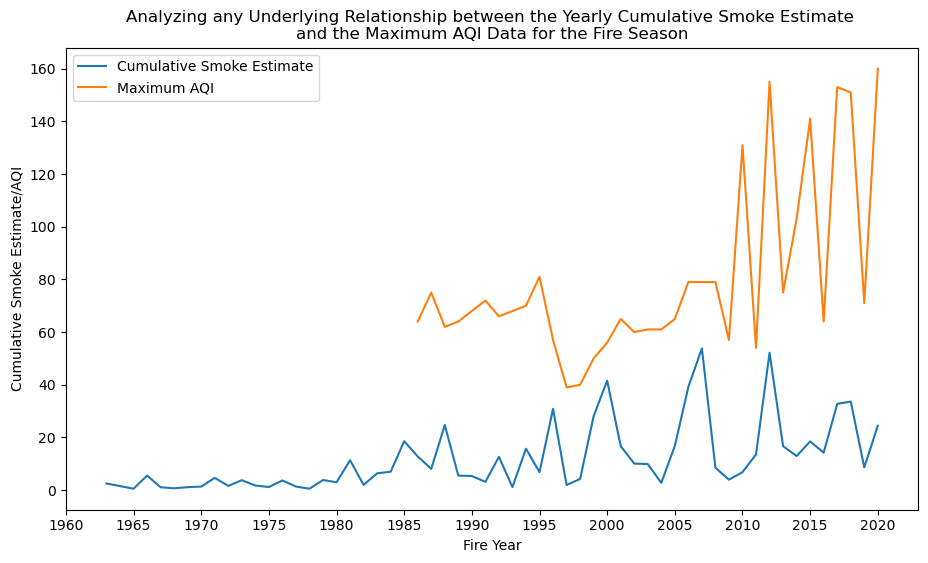

In [16]:
# Plot the cumulative smoke estimate and the maximum AQI data for every year
plt.figure(figsize=(11, 6))
plt.plot(smoke_by_year['Fire_Year'], smoke_by_year['Smoke_Estimate'], label='Cumulative Smoke Estimate')
plt.plot(aqi_df['Year'], aqi_df['AQI'], label='Maximum AQI')

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate/AQI')
plt.title('Analyzing any Underlying Relationship between the Yearly Cumulative Smoke Estimate \n\
and the Maximum AQI Data for the Fire Season')
plt.xlim([1960, 2023]) 
plt.xticks(np.arange(1960, 2023, 5))
plt.legend()
plt.show()

As evident from the above plot, the Maximum AQI data for the fire season of every year is missing for the years 1963-1985. However, for the years where the data is available, there seems to be a somewhat dependent relationship between the two variables - Cumulative Smoke Estimate and the Maximum AQI. The peaks and dips are mostly in sync for both the curves. However, there are a few instances where these don't match.

The AQI measures air pollution levels, which can arise from various sources, not solely wildfires. While wildfires are a significant contributor to poor air quality and can substantially impact the AQI, other factors and sources also influence air pollution levels. Some of these other sources are industrial emissions, vehicle emissions, construction activities, etc. Thus, while there might be a relationship between both the variables we cannot assume that wildfires are the sole reason for poor AQI.

Overall, the curves are quite smilar in their trends indicating that our smoke estimate is capturing the data well.

### Step 6: Modeling the Smoke Estimate

The plot of the Cumulative Smoke Estimate shows continous peaks and falls which are difficult to capture using a regression model. The moving average model, often used to predict stock prices that are quite volatile, can be used in this case to model the Smoke Estimate data.

The AQI data can also be added as a feature in this model. However, since the AQI data is missing for more than 20 years, we will only use the smoke estimate to compute the rolling average. The model that will be used for this analysis is Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) model.

For the model to be applied, the date column needs to be set as the index of the dataframe. It also needs to be changed to the pandas datetime object.

In [17]:
# Create a copy of the dataframe containing yearly cumulative smoke estimate data
sarimax_df = smoke_by_year.copy()

# Convert the year column to datetime and save it as a new column called 'date'
sarimax_df['date'] = pd.to_datetime(sarimax_df['Fire_Year'], errors='ignore', format='%Y')

# Set the above date column as the dataframe's index
sarimax_df = sarimax_df.set_index('date')

# Change the index to datetime object and convert into the type 'datetime64[ns]'
# It is important to convert it to the type 'datetime64[ns]' because the default type is numpy datetime
# A datetime format other than 'datetime64[ns]' throws an error while training the model
sarimax_df.index = pd.to_datetime(sarimax_df.index).astype('datetime64[ns]')

# We then drop the 'Fire_Year' column as it is no longer needed
sarimax_df.drop(['Fire_Year'], axis=1, inplace=True)

In [18]:
# Look at the top of the dataframe
sarimax_df.head()

,Smoke_Estimate
date,
1963-01-01,2.511617
1964-01-01,1.550112
1965-01-01,0.536063
1966-01-01,5.535176
1967-01-01,1.087652


Now that we have prepared our dataset for the model, we can go ahead and train it.

In [19]:
# Fit a SARIMAX model
# Set the order and season_order parameters as per your requirements
# The fourth coordinate of the seasonal_order parameter is set to 12 for yearly data
model = sm.tsa.SARIMAX(sarimax_df['Smoke_Estimate'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Generate a list of years for our range of 1963 to 2020
years_range = np.arange(1963, 2021, 1)

# Create a datetime index with the type 'datetime64[ns]'
future_index = pd.to_datetime(years_range, format='%Y').astype('datetime64[ns]')

# Generate predictions using the start date, end date and the time-series index
forecast = results.get_prediction(start=future_index[0], end=future_index[-1], exog=sarimax_df.index)

# Extract the predicted mean values for the years 1963 to 2020
Y_pred = list(forecast.predicted_mean)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29905D+00    |proj g|=  2.15893D-01

At iterate    5    f=  3.17327D+00    |proj g|=  5.39044D-02

At iterate   10    f=  3.10578D+00    |proj g|=  1.42841D-02

At iterate   15    f=  3.08942D+00    |proj g|=  2.37390D-03

At iterate   20    f=  3.08737D+00    |proj g|=  9.11857D-03

At iterate   25    f=  3.08706D+00    |proj g|=  6.78834D-04

At iterate   30    f=  3.08684D+00    |proj g|=  4.37860D-03


 This problem is unconstrained.



At iterate   35    f=  3.08676D+00    |proj g|=  6.20925D-04

At iterate   40    f=  3.08675D+00    |proj g|=  2.68571D-04

At iterate   45    f=  3.08675D+00    |proj g|=  7.87507D-05

At iterate   50    f=  3.08675D+00    |proj g|=  7.03739D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62      1     0     0   7.037D-06   3.087D+00
  F =   3.0867476374719112     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


Now we plot the original data and the fitted model to understand the model performance.

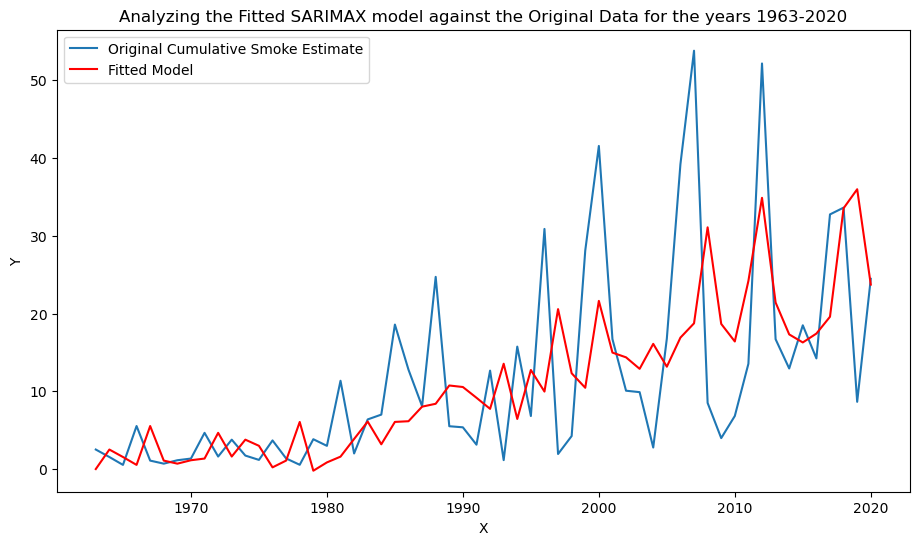

In [20]:
# Plot the original data with the fitted model
X = list(smoke_by_year['Fire_Year'])
Y = list(smoke_by_year['Smoke_Estimate'])

plt.figure(figsize=(11, 6))
plt.plot(X, Y, label='Original Cumulative Smoke Estimate')

# Plot the fitted model line
plt.plot(X, Y_pred, 'r-', label='Fitted Model')

# Set labels and show plot
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Analyzing the Fitted SARIMAX model against the Original Data for the years 1963-2020')
plt.legend()
plt.show()

The model does not fully capture the data for the current period, and there is quite some scope for improvement. However, we also do not want to overfit the data. We will go ahead with this model and generate predictions for the smoke estimate.

### Step 7: Generating Predictions for the Years 2021-2049

We will now use the trained model above to predict smoke estimates for every year for the next 29 years (i.e., 2021-2049). While we are currently in the year 2023, predictions are being generated from 2021 onwards since the Smoke Estimate data is available until 2020 only. We will also make sure to convey appropriate levels of uncertainty in our predictions.

The first step thus will be to generate predictions and confidence intervals.

In [21]:
# Generate a list of years for our range of 2021 to 2049
years_range = np.arange(2021, 2050, 1)

# Create a datetime index with the type 'datetime64[ns]'
future_index = pd.to_datetime(years_range, format='%Y').astype('datetime64[ns]')

# Generate predictions using the start date, end date and the time-series index
forecast = results.get_prediction(start=future_index[0], end=future_index[-1], exog=sarimax_df.index)

# Extract the predicted mean values for the years 2021 to 2049 and their confidence intervals
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

Now we will plot our predictions with their uncertainty along with the original data.

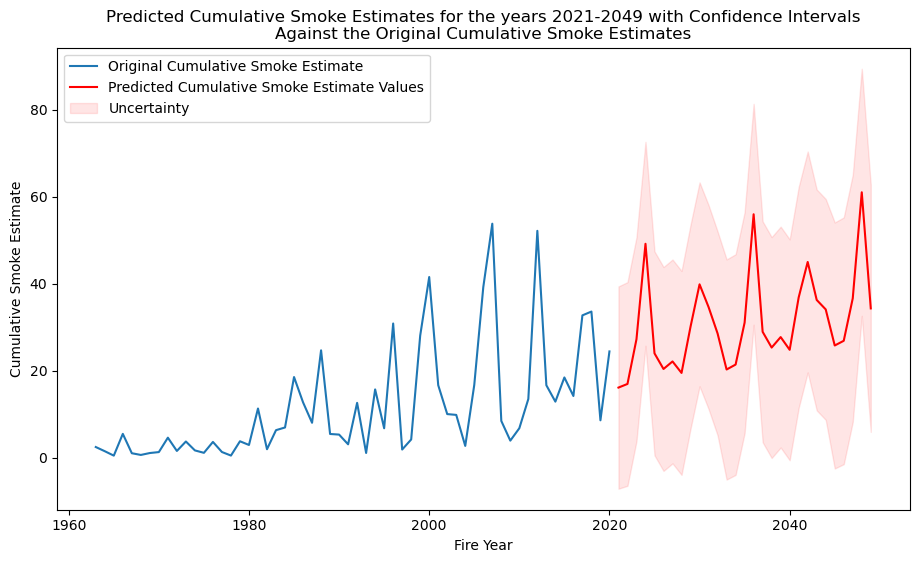

In [22]:
# Plot the actual data
plt.figure(figsize=(11, 6))
plt.plot(X, Y, label='Original Cumulative Smoke Estimate')

# Plot the predicted values
plt.plot(years_range, forecast_values, color='red', label='Predicted Cumulative Smoke Estimate Values')

# Plot the confidence intervals
plt.fill_between(
    years_range,
    list(confidence_intervals.iloc[:, 0]),
    list(confidence_intervals.iloc[:, 1]),
    color='red', alpha=0.1, label='Uncertainty'
)

# Set labels and show plot
plt.legend(loc='upper left')
plt.title('Predicted Cumulative Smoke Estimates for the years 2021-2049 with Confidence Intervals\n\
Against the Original Cumulative Smoke Estimates')
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate')
plt.show()

The predictions look quite reasonable where the 3-5 years periodic frequency of peaks and dips is maintained. The height of the peaks alternatively goes up and down.

### Step 8: Creating Final Visualizations

We will now illustrate the work of our analysis with a few time series graphs. The wildfire data is annual, so our time series will be on an annual basis. All the time series will cover the analysis range for the years 1963-2020, but not the prediction range.

**1. Distribution of Wildfires by their Distance from Twin Falls, Idaho**

We will produce a histogram showing the number of fires occurring every 50 mile distance from Twin Falls, Idaho up to 1250 miles.

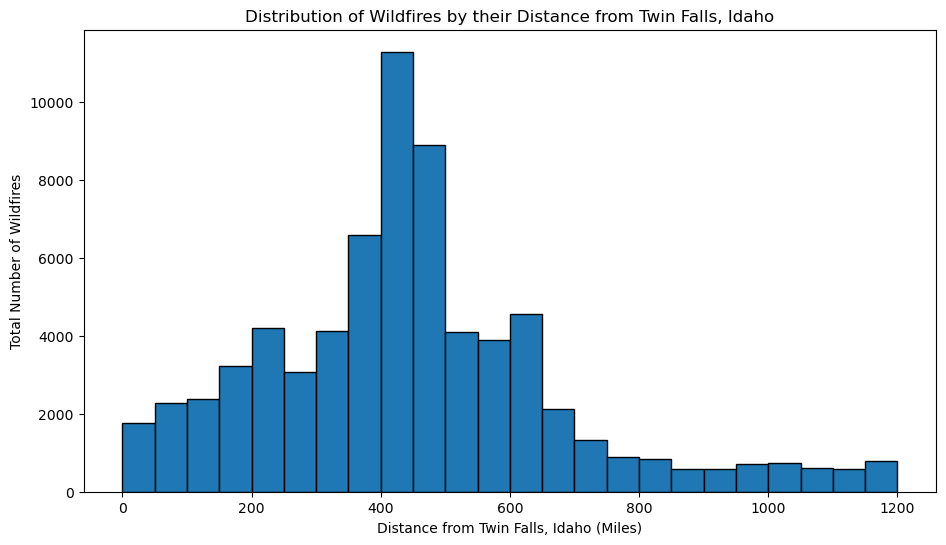

In [23]:
# Plot the distribution of wildfires by their distance from Twin Falls, Idaho
plt.figure(figsize=(11, 6))
bins = np.arange(0, 1250, 50)
plt.hist(wf_df['Distance'], bins=bins, edgecolor='black')

# Set labels and show plot
plt.xlabel('Distance from Twin Falls, Idaho (Miles)')
plt.ylabel('Total Number of Wildfires')
plt.title('Distribution of Wildfires by their Distance from Twin Falls, Idaho')
plt.show()

It can be observed that the most number of wildfires occur around the 400-450 miles radius of Twin Falls, Idaho.

**2. Total Acres Burned by Year**

We will produce a time series graph of total acres burned per year for the fires occurring within 1250 miles of Twin Falls, Idaho.

In [24]:
# Group the data by year and calculate the total burnt acres
acres_by_year = wf_df.groupby(['Fire_Year'])['GIS_Acres'].sum().reset_index()

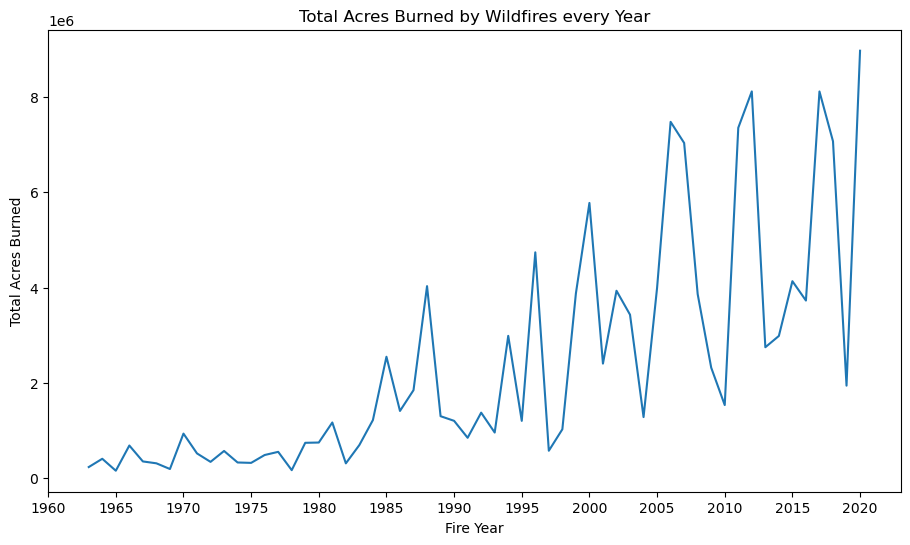

In [25]:
# Plot the total acres burnt every year
plt.figure(figsize=(11, 6))
plt.plot(acres_by_year['Fire_Year'], acres_by_year['GIS_Acres'])

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned by Wildfires every Year')
plt.xlim([1960, 2023]) 
plt.xticks(np.arange(1960, 2023, 5))
plt.show()

The total acres burned by wildfires has a lot of peake and dips. Overall, the height of the peaks is steadily increasing indicating that more and more acreage is burned over the years.

**3. Time Series Containing Fire Smoke Estimate and the AQI Estimate**

We will produce a time series graph containing our fire smoke estimate for and the AQI estimate for Twin Falls, Idaho.

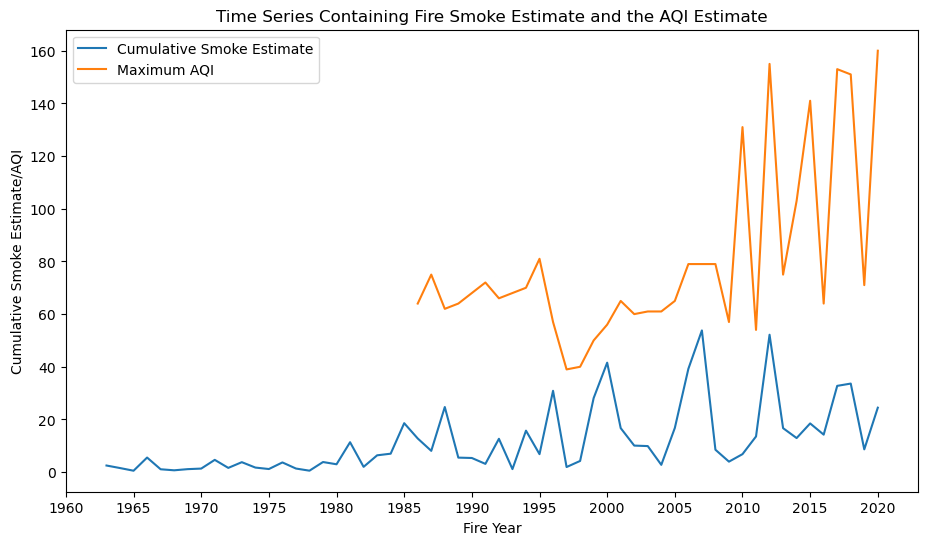

In [26]:
# Plot the cumulative smoke estimate and the maximum AQI data for every year
plt.figure(figsize=(11, 6))
plt.plot(smoke_by_year['Fire_Year'], smoke_by_year['Smoke_Estimate'], label='Cumulative Smoke Estimate')
plt.plot(aqi_df['Year'], aqi_df['AQI'], label='Maximum AQI')

# Set labels and show plot
plt.xlabel('Fire Year')
plt.ylabel('Cumulative Smoke Estimate/AQI')
plt.title('Time Series Containing Fire Smoke Estimate and the AQI Estimate')
plt.xlim([1960, 2023]) 
plt.xticks(np.arange(1960, 2023, 5))
plt.legend()
plt.show()

As evident from the above plot, the Maximum AQI data for the fire season of every year is missing for the years 1963-1985. However, for the years where the data is available, there seems to be a somewhat dependent relationship between the two variables - Cumulative Smoke Estimate and the Maximum AQI. The peaks and dips are mostly in sync for both the curves. However, there are a few instances where these don't match.

All the above plots have been explained in detail in the reflection of the project. Please refer that for more information.